In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
%matplotlib inline

In today's demonstration, we will show you how to generate the predicted BOLD signal of a simple block design fMRI experiment. In fact, we will be making the predicted BOLD signal for an experiment run by a couple of PNI graduent students a few years ago (more on that later).

## Section 1: Load and inspect the fMRI data

In this first section, we will load and inspect fMRI data from one participant. As a reminder, this participant completed an experiment where they watched alternating blocks of a [visual checkerboard](https://www.youtube.com/watch?v=xEd1h_lz4rA) (warning: flashing lights) and an empty black background. Each stimulus (i.e. checkerboard, blank screen) was presented for 20 seconds a time. 

We will use a new python package, `nibabel`, to open this participant's raw data file.

In [2]:
import nibabel as nib

## Specify path to file.
f = 'sub-01_task-visualcontrol_space-T1w_desc-preproc_bold.nii.gz'

## Load functional data.
func = nib.load(f).get_fdata()
print('Functional data dim:\t(X=%s, Y=%s, Z=%s, T=%s)' %func.shape)

Functional data dim:	(X=50, Y=59, Z=1, T=250)


As the data's dimensions note, the data is a 4d matrix: three spatial dimensions and time. The x-axis defines the space between the left to right hemispheres. The y-axis defines the space from anterior to posterior (front to back). The z-axis defines the space from dorsal to ventral (top to bottom). Each element of this matrix is known as a **voxel**, or a 3d pixel, and is a measurement of the BOLD response at a given point and time during the scan. For this scan, each voxel was approximately $2 \text{mm}^3$.

As you may have noticed, the z-axis is only one voxel deep. To simplify the analysis today, you will be analyzing only one **axial slice** (i.e. one horizontal slice) of this participant's brain. 

Let's begin by inspecting the brain. We can do this averaging over all time points (i.e. the 4th dimension). After averaging (and squeezing), use either Matplotlib's (`plt.imshow`) or Seaborn's (`sns.heatmap`) heatmap function to visualize the brain. We recommend setting `cmap=binary_r` for best results.

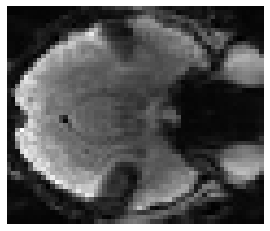

In [3]:
## Average and squeeze.
avg = func.mean(axis=-1).squeeze()

## Plot.
sns.heatmap(avg, cmap='binary_r', cbar=False, square=True, xticklabels=[], yticklabels=[]);

In the image above, can you find the visual cortex? (Hint: in raw, unmasked fMRI data, the eyeballs are still visually prominent.)

The image above suggests we need to perform **masking**. That is, we need to remove the voxels corresponding to (oxygen-rich) non-neural tissues including the eyes and skull layers. Fortunately for us, we have an anatomical reference image for this participant that has undergone **skull-stripping** (i.e. digital removal of non-neural tissues).

We load in this image below.

In [4]:
## Specify path to file.
f = 'sub-01_task-visualcontrol_space-T1w_desc-boldref.nii.gz'

## Load anatomical data.
anat = nib.load(f).get_fdata()
print('Anatomical data dim:\t(X=%s, Y=%s, Z=%s)' %anat.shape)

Anatomical data dim:	(X=50, Y=59, Z=1)


As you can see, the anatomical reference image is a single snapshot with the same spatial dimensions as the functional data. To confirm that skull-stripping has worked, plot the anatomical reference image below using a heatmap function just like in the previous step.

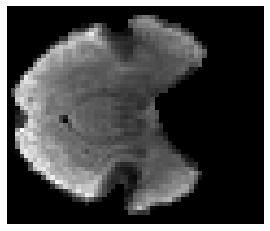

In [5]:
## Plot.
sns.heatmap(anat.squeeze(), cmap='binary_r', cbar=False, square=True, xticklabels=[], yticklabels=[]);

The anatomical reference looks good! The skull layers and eyes have been successfully removed. We will use this image to mask our functional data.

Define a new matrix `mask` that indicates where any voxel in our anatomical reference image `anat` is greater than zero. Visualize the mask template to make sure your method worked.

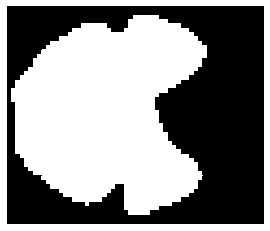

In [6]:
## Define mask image.
mask = anat > 0

## Plot.
sns.heatmap(mask.squeeze(), cmap='binary_r', cbar=False, square=True, xticklabels=[], yticklabels=[]);

## Section 2: Filtering and Percent Signal Change

Just like electrophysiological data, fMRI data is also usually filtered prior to analysis. Highpass filtering fMRI data is useful as it removes low frequency drifts in the fMRI signal. (For a great overview of sources of noise in fMRI data, see [Greve et al., 2013](https://doi.org/10.1007/s11336-012-9294-0).) Highpass filtering can be performed in a number of ways, but thankfully `nilearn` makes this very easy for us. We will use the `clean` function to highpass filter the data. The appropriate frequency cutoff may depend on your particular experiment, but standard values are 1/100 (0.01) Hz, 1/128 Hz (0.0078), and 1/200 (0.005) Hz. 

If you do not have the `nilearn` package installed, open a terminal and run:

```bash
pip install nilearn
```

Importantly, applying a highpass filter will demean our data (i.e. subtract the mean from each voxel). This is not ideal if we are interested in converting our data to percent signal change ([Chen et al. 2017](https://www.sciencedirect.com/science/article/pii/S1053811916305432)). Thus, we will store the mean intensities of each voxel prior to filtering.



In [7]:
from nilearn.signal import clean

## Define filtering parameters.
high_pass = 1 / 100.
tr = 1

## Reshape the data for filtering.
nx, ny, nz, nt = func.shape
raw = func.reshape(-1,nt).T

## Compute mean signal.
mu = raw.mean(axis=0)

## Apply highpass data.
filt = clean(raw, detrend=True, standardize=False, high_pass=high_pass, t_r=tr)

## Convert to percent signal change.
filt = filt / mu * 100

## Shape back into original dimensions.
filt = filt.T.reshape(nx,ny,nz,nt)

Let's inspect the filtered brain. average over all the time points (i.e. the 4th dimension) of the new matrix `filt`. After averaging (and squeezing), make a heatmap of the averaged image. How does the image look now?

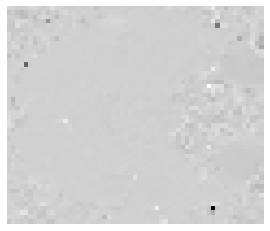

In [8]:
## Average and squeeze.
avg = filt.mean(axis=-1).squeeze()

## Plot.
sns.heatmap(avg, cmap='binary_r', cbar=False, square=True, xticklabels=[], yticklabels=[]);

If the brain is harder to see now, that's good! That's because what normally separates the brain from the background image is the average voxel intensity (average BOLD signal) which is much higher in biological tissue. After filtering, however, we've demeaned and normalized the brain so that this average intensity has been removed. This is helpful for our analysis because it now makes measurements of BOLD signal change comparable across the brain.

Let's now use our brain mask to mask all voxels not corresponding to neural tissue. Use the brain mask to index into `filt` and set all non-neural voxels (i.e. all voxels in `mask` with a value less than one) to zero.

In [9]:
## Mask data.
filt[~mask] = 0

To confirm that this procedure worked, remake the image from the step above. It should be easier now to tell brain from non-brain.

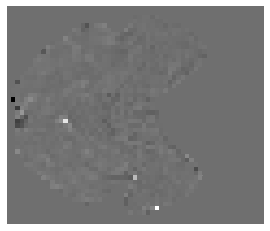

In [10]:
## Average and squeeze.
avg = filt.mean(axis=-1).squeeze()

## Plot.
sns.heatmap(avg, cmap='binary_r', cbar=False, square=True, xticklabels=[], yticklabels=[]);

## Section 3: Design Matrix & Regression

In this step, similar to what you did last time, we will make the predicted BOLD signal in response to our alternating visual checkerboard stimulus. Now that you know how to make the predicted BOLD signal, we will not have you repeat every step. Instead, we will have you use a new function, `fmritools.design.design_matrix`, that will generate the BOLD timeseries for you.

Importantly, the function `design_matrix` requires three important pieces of information: (1) the repetition time (TR), or length of time to collect one image, (2) the total number of images collected, and (3) a 3-column matrix, `events`, where each column corresponds to a stimulus onset, offset, and condition, respectively. 

Fortunately, you have all of this information! We know the TR=1, and from above, we know our data has T=250 total timepoints. From last session, you know the event onsets and offsets. **Important:** For this participant's data, the first checkerboard stimulus appeared 10s after the start of the scan. That is, all of your onsets/offsets from last time should be shifted forwards by 10s. 

Make the 3-column `events` matrix, where the first column is *onsets*, the second column is *offsets*, and the third column is an array of ones.

In [11]:
## Define events.
onsets  = [10,50,90,130,170,210]
offsets = [30,70,110,150,190,230]
conds = [1,1,1,1,1,1]

events = np.column_stack([onsets, offsets, conds])

Now we will generate our design matrix. Note, we are also having the `design_matrix` function return our generated boxcar function for comparison.

In [12]:
from fmritools.design import design_matrix

## Define task metadata.
n_acq = 250
tr = 1

## Make design matrix.
times, bold, boxcars = design_matrix(tr, n_acq, events, return_boxcars=True)

To confirm that the function worked, plot the boxcar function and predicted BOLD signal on the same plot.

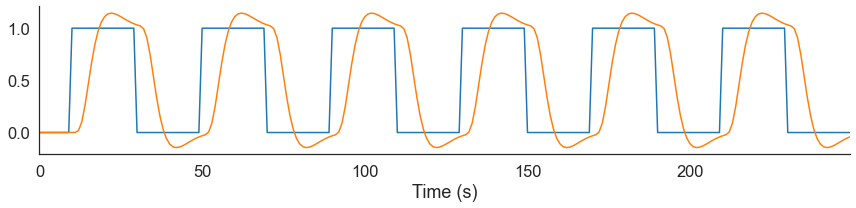

In [13]:
## Intialize canvas.
fig, ax = plt.subplots(1,1,figsize=(12,3))

## Plot.
ax.plot(times, boxcars)
ax.plot(times, bold)
ax.set(xlim=(times.min(), times.max()), xlabel='Time (s)')

sns.despine()
plt.tight_layout()

The moment has arrived! We will now regress our predicted BOLD signal against our participant's observed BOLD signal. 

Like last time, we need to construct our design matrix, `X`. Our design matrix will be comprised of two arrays: an *intercept* and `bold` timeseries. The intercept is just an array made entirely of 1s. Using `np.ones_like` and `np.column_stack`, make our design matrix `X` in the cell below.

In [14]:
X = np.column_stack([np.ones_like(bold), bold])

Let's perform regression! Note, we perform some ugly data reshaping in order to regress our design matrix against every voxel in our participant's brain slice simultaneously.

In [15]:
## Define image dimensions.
nx, ny, nz, nt = filt.shape

## Perform regression.
coef, _, _, _ = np.linalg.lstsq(X,filt.reshape(-1,nt).T,rcond=-1)

## Reshape regression coefficients.
coef = coef.T.reshape(nx,ny,nz,-1)[...,-1]

Now let's plot the regression coefficients. They will be easier to interpret if we overlay them on top of the reference anatomical image. To do this, we will make two heatmaps in the same subplot: first the anatomical image, then the regression coefficients. Importantly, we will threshold the coefficients such that values beneath the threshold will not be visualized. 

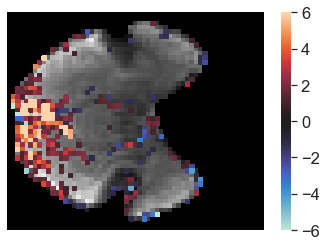

In [16]:
## Define threshold.
threshold = 1

## Mask coefficients.
viz = np.where(np.abs(coef) > threshold, coef, np.nan)

## Plot.
sns.heatmap(anat.squeeze(), cmap='binary_r', cbar=False, square=True, xticklabels=[], yticklabels=[]);
sns.heatmap(viz.squeeze(), vmin=-6, vmax=6, center=0, square=True, xticklabels=[], yticklabels=[]);

Questions to ponder:
1. The units of the coefficients are in percent signal change. What does this mean? What does a threshold of 1 mean?
2. Is there one area of the brain that seems more active (i.e. greater change in BOLD signal)? Is this in line with your expectations?

## Section 4: Region of Interest Analysis

By now, it should be clear that this task robustly activates visual cortex. This is unsurprising: that's exactly what visual checkerboards are good at!

In this final step, let's extract the BOLD signal from voxels strongly activated by the task. To do this mask, use the `coef` matrix to index into the `filt` timeseries. Extract all voxels from `filt` with a corresponding coefficient greater than 5. 

In [17]:
## Extract BOLD signal.
roi = filt[coef > 5]

Now, average over each voxel in this new matrix and plot the resulting timeseries. What does it look like? 

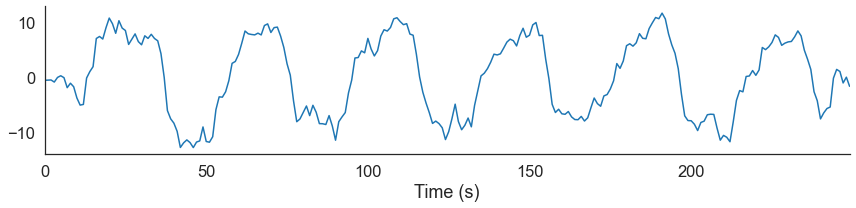

In [18]:
## Intialize canvas.
fig, ax = plt.subplots(1,1,figsize=(12,3))

## Plot.
ax.plot(times, roi.mean(axis=0))
ax.set(xlim=(times.min(), times.max()), xlabel='Time (s)')

sns.despine()
plt.tight_layout()

## Figure Ideas
1. Plot the observed BOLD signal change in visual cortex against the predicted BOLD signal. How do they compare? 
2. Plot the observed BOLD signal change in visual cortex compared to a collection of voxels outside of visual cortex. How do they compare?

In describing your figures, remember to briefly describe the experiment (e.g. what the participant saw and for how long). Please also interpret the units; that is, describe what percent signal change means. 